# **Polynomial Ridge Regression From scratch**

In [49]:
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("Fuel-type-E.csv")

# Separate features (X) and target (y)
X = df.drop('CO2 Emissions(g/km)', axis=1).values
y = df['CO2 Emissions(g/km)'].values.reshape(-1, 1)

# Funtions

In [62]:
def save_weights_to_npy(w, b, std, mean, weight_file="weights_poly_trad.npy", bias_file="bias_poly_trad.npy"
                        , std_file="std_poly_trad.npy", mean_file="mean_poly_trad.npy"):
    np.save(weight_file, w)
    np.save(bias_file, np.array([b]))
    np.save(std_file, std)
    np.save(mean_file, mean)

def polynomial_features(X, degree):
    """
    Generate polynomial features for input matrix X up to a given degree.
    Parameters:
        X: numpy array of shape (m, n)
        degree: int, highest polynomial degree to generate
    Returns:
        X_poly: numpy array of shape (m, num_features)
    """
    m, n = X.shape
    features = [np.ones((m, 1))]  # Bias term: degree 0
    
    for deg in range(1, degree + 1):
        for combo in combinations_with_replacement(range(n), deg):
            # Multiply columns based on index combo
            col = np.ones(m)
            for idx in combo:
                col *= X[:, idx]
            features.append(col.reshape(-1, 1))
    
    return np.hstack(features)

def compute_cost(x, y, w, b):
    m,n = x.shape

    f_wb = np.dot(x,w) + b
    cost = (1/(2 *m)) * np.sum((f_wb - y)**2)
    return cost

def compute_gradient(x, y, w, b, L2_reg):
    m = x.shape[0]

    f_wb = np.dot(x, w) + b         
    error = f_wb - y                

    dj_dw = ((1/m) * np.dot(x.T, error)) + ((L2_reg/m) * w)  #L2 regularization term. (shape (n, 1))
    dj_db = ((1/m) * np.sum(error))       # scalar

    return dj_dw, dj_db

def gradient_descent(lr, x, y, w, b, L2_reg, method, previous_cost, threshold, max_iters):
    
    m = x.shape[0]
    iters = 0
    L2_reg = L2_reg
    #Logs for tracking
    cost_log = []
    iteration_log = []
    weight_log = []
    bias_log = []

    method = method.lower()

    if method == 'adam':
        
        v_w, v_b, s_w, s_b = np.zeros_like(w), 0.0, np.zeros_like(w), 0.0
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8

        while True:

            dj_dw, dj_db = compute_gradient(x, y, w, b, L2_reg)

            v_w_corrected, v_b_corrected, s_w_corrected, s_b_corrected, v_w, v_b, s_w, s_b = compute_adam_update(dj_dw, dj_db, v_w, v_b, s_w, s_b, beta1, beta2, iters)
            
            w -= lr * v_w_corrected / (np.sqrt(s_w_corrected) + epsilon)
            b -= lr * v_b_corrected / (np.sqrt(s_b_corrected) + epsilon)
            
            current_cost = compute_cost(x, y, w, b)

            # if iters % 100 == 0:
            #     print(f"Iteration {iters} | Cost: {current_cost:.5f} | w: {w.ravel()} | b: {b:.5f}")

            #     #Log the cost, iteration, weights, and bias
            #     if iters < 1001 and iters % 100 == 0 and iters > 1:
            #         cost_log.append(current_cost)
            #         iteration_log.append(iters)
            #         weight_log.append(w.flatten().tolist())  # Save as list
            #         bias_log.append(b)
            #     elif iters < 10000 and iters > 1001 and iters % 500 == 0:
            #         cost_log.append(current_cost)
            #         iteration_log.append(iters)
            #         weight_log.append(w.flatten().tolist())  # Save as list
            #         bias_log.append(b)

            if abs(current_cost - previous_cost) < threshold:
                print(f"Converged in {iters} iterations.")
                break
            
            previous_cost = current_cost
            iters += 1

            if iters >= max_iters:
                print("Stopped: Max iterations reached.")
                break


    elif method == 'vanilla' or method == 'gd':
        while True:
            
            dj_dw, dj_db = compute_gradient(x, y, w, b)

            w = w - (lr/m)*(dj_dw)
            b = b - (lr/m)*(dj_db)

            current_cost = compute_cost(x, y, w, b, L2_reg)

            # if iters % 100 == 0:
            #     print(f"Iteration {iters} | Cost: {current_cost:.5f} | w: {w.ravel()} | b: {b:.5f}")
                
                # Log the cost, iteration, weights, and bias
                # if iters < 1001 and iters % 100 == 0 and iters > 1:
                #     cost_log.append(current_cost)
                #     iteration_log.append(iters)
                #     weight_log.append(w.flatten().tolist())  # Save as list
                #     bias_log.append(b)
                # elif iters < 10000 and iters > 1001 and iters % 1000 == 0:
                #     cost_log.append(current_cost)
                #     iteration_log.append(iters)
                #     weight_log.append(w.flatten().tolist())  # Save as list
                #     bias_log.append(b)
             
            if abs(current_cost-previous_cost) < threshold:
                print(f"Converged in {iters} iterations.")
                break

            previous_cost = current_cost
            iters += 1
            if iters >= max_iters:
                print("Stopped: Max iterations reached.")
                break

    else:
        raise ValueError(f"Unsupported optimization method: {method}")

    return w , b #,cost_log , iteration_log , weight_log , bias_log

def predict(x_test_scaled, w, b):
    return np.dot(x_test_scaled,w) + b

def compute_adam_update(dj_dw, dj_db, v_w, v_b, s_w, s_b, beta1 , beta2  , iters):
    # Update biased first moment estimates
    v_w = beta1 * v_w + (1 - beta1) * dj_dw
    v_b = beta1 * v_b + (1 - beta1) * dj_db

    # Update biased second moment estimates
    s_w = beta2 * s_w + (1 - beta2) * (dj_dw ** 2)
    s_b = beta2 * s_b + (1 - beta2) * (dj_db ** 2)

    # Compute bias-corrected first moment estimates
    v_w_corrected = v_w / (1 - beta1 ** (iters + 1))
    v_b_corrected = v_b / (1 - beta1 ** (iters + 1))

    # Compute bias-corrected second moment estimates
    s_w_corrected = s_w / (1 - beta2 ** (iters + 1))
    s_b_corrected = s_b / (1 - beta2 ** (iters + 1))

    return v_w_corrected, v_b_corrected, s_w_corrected, s_b_corrected, v_w, v_b, s_w, s_b

def adam_gradient_descent(lr, x, y, w, b, previous_cost, threshold, max_iters):
    m = x.shape[0]
    iters = 0
    cost_log = []
    iteration_log = []
    weight_log = []
    bias_log = []

    # Initialize Adam parameters
    v_w = np.zeros_like(w)
    v_b = 0.0
    s_w = np.zeros_like(w)
    s_b = 0.0
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    while True:
        dj_dw, dj_db = compute_gradient(x, y, w, b)

        # Update biased first moment estimates
        v_w = beta1 * v_w + (1 - beta1) * dj_dw
        v_b = beta1 * v_b + (1 - beta1) * dj_db

        # Update biased second moment estimates
        s_w = beta2 * s_w + (1 - beta2) * (dj_dw ** 2)
        s_b = beta2 * s_b + (1 - beta2) * (dj_db ** 2)

        # Compute bias-corrected first moment estimates
        v_w_corrected = v_w / (1 - beta1 ** (iters + 1))
        v_b_corrected = v_b / (1 - beta1 ** (iters + 1))

        # Compute bias-corrected second moment estimates
        s_w_corrected = s_w / (1 - beta2 ** (iters + 1))
        s_b_corrected = s_b / (1 - beta2 ** (iters + 1))

        # Update parameters
        w -= lr * v_w_corrected / (np.sqrt(s_w_corrected) + epsilon)
        b -= lr * v_b_corrected / (np.sqrt(s_b_corrected) + epsilon)

        current_cost = compute_cost(x, y, w, b)

        if iters % 100 == 0:
            print(f"Iteration {iters} | Cost: {current_cost:.5f} | w: {w.ravel()} | b: {b:.5f}")

        if abs(current_cost - previous_cost) < threshold:
            print(f"Converged in {iters} iterations.")
            break

        previous_cost = current_cost

    return w, b
    

In [51]:
#Converting X to polynomial features
X = polynomial_features(X, degree=5)

# Step 1: Shuffle the data
np.random.seed(42)  # for reproducibility
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]


# Step 2: 80/20 split
split_index = int(0.8 * X.shape[0])
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


# Step 3: Z-score normalization (standardization) for X
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Avoid division by zero
std[std == 0] = 1.0

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std  # use train mean & std!

# Step 4: Initialize parameters
m, n = X_train_scaled.shape
w = np.random.uniform(low=-1.0, high=1.0, size=(n, 1))
b = 0.0

**BGD with Adam optimizer**

In [63]:
wf , bf = gradient_descent(0.2,X_train_scaled,y_train,w,b,L2_reg=.2,method='adam',previous_cost=float('inf'),threshold=1e-7,max_iters=100000)

Converged in 4110 iterations.


### **Model Evaluation**

##### Training Set Metrics:

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_train = predict(X_train_scaled, wf, bf)

# Calculate metrics
mse_t = mean_squared_error(y_train, y_pred_train)
mae_t = mean_absolute_error(y_train, y_pred_train)
r2_t = r2_score(y_train, y_pred_train)

# Print results
print(f"\n📊 Training Metrics (from sklearn):")
print(f"Mean Squared Error (MSE): {mse_t:.4f}")
print(f"Mean Absolute Error (MAE): {mae_t:.4f}")
print(f"R² Score: {r2_t:.4f}")


📊 Training Metrics (from sklearn):
Mean Squared Error (MSE): 21.7120
Mean Absolute Error (MAE): 4.0225
R² Score: 0.9894


##### **Testing Set Metrics**

In [54]:
# Predict on test set
y_pred_test = predict(X_test_scaled, wf, bf)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

# Print results
print(f"\n📊 Test Metrics (from sklearn):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


📊 Test Metrics (from sklearn):
Mean Squared Error (MSE): 87.8976
Mean Absolute Error (MAE): 5.1858
R² Score: 0.9677


In [55]:
df["CO2 Emissions(g/km)"].describe()

count    370.000000
mean     275.091892
std       47.093198
min      128.000000
25%      248.000000
50%      279.000000
75%      299.000000
max      418.000000
Name: CO2 Emissions(g/km), dtype: float64

# Interpretation:

✅ Test R² (0.9677) is very close to Train R² (0.9894) — great generalization, no overfitting

✅ MSE Test (87.8976) vs MSE Train (21.7170) — MSE on test is high perhaps due to the Outlier seen in residual scatter plot. MSE is prone to Outliers. On the other hand MAE:

✅ MAE Test (5.1858) vs MAE Train (4.0225) — MAE on Test is marginally higher.

✅ Both train & test performance confirm that optimization path is strong and stable.

### **Visualizations:**

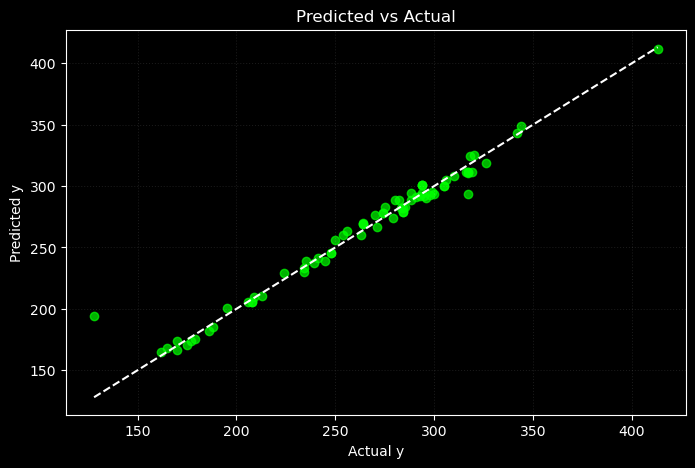

In [56]:
plt.figure(figsize=(8, 5))
plt.style.use('default')

plt.scatter(y_test, y_pred_test, color='lime', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='white', linestyle='--')

plt.gca().set_facecolor('black')
plt.gcf().patch.set_facecolor('black')  # This line removes the white outer area

plt.xlabel("Actual y", color='white')
plt.ylabel("Predicted y", color='white')
plt.title("Predicted vs Actual", color='white')
plt.tick_params(colors='white')

for spine in plt.gca().spines.values():
    spine.set_color('white')

plt.grid(True, linestyle=':', color='white', alpha=0.1)
plt.show()

Most predictions are close to the dashed line, Which means Model predicts exceptionally well. 
As suspected 1 outlier spoils the MAE and MSE.

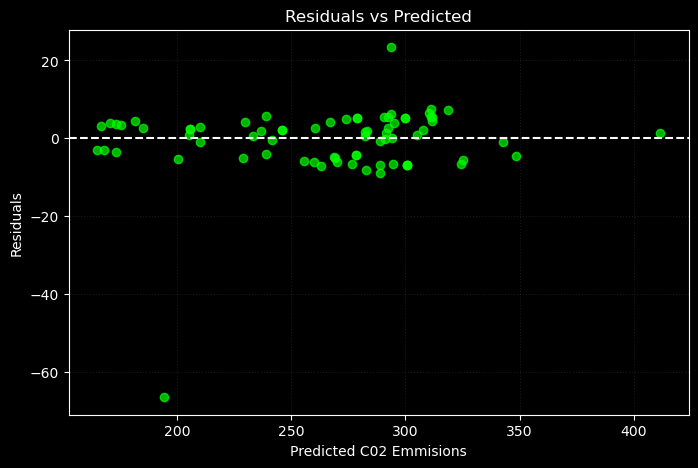

In [57]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 5))
plt.style.use('default')

# Basic plot with lime points and black background
plt.scatter(y_pred_test, residuals, color='lime', alpha=0.7)
plt.axhline(0, color='white', linestyle='--')

# Black background and white text
plt.gca().set_facecolor('black')
plt.gcf().patch.set_facecolor('black')  # This line removes the white outer area
plt.xlabel("Predicted C02 Emmisions", color='white')
plt.ylabel("Residuals", color='white')
plt.title("Residuals vs Predicted", color='white')
plt.tick_params(colors='white')

# White border
for spine in plt.gca().spines.values():
    spine.set_color('white')

plt.grid(True, linestyle=':', color='white', alpha=0.1)
plt.show()

Due to the outlier it is hard to extrapolate anything. But upon close inspection. One can deduce the model might need some L2 regularization to improve the scatter and combat potential overfitting

In [58]:
#save_weights_to_npy(wf, bf,std, mean)

In [ ]:
#Converting logs to DataFrame
df_log = pd.DataFrame({
    'iteration': iteration_log,
    'cost': cost_log,
    'bias': bias_log,
})

#Saving log
#df_log.to_csv('gd_convergence_log.csv', index=False)